## IMPORTS

In [960]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.ensemble import IsolationForest

from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

from sklearn.metrics import root_mean_squared_error, mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE

from sklearn.model_selection import  cross_val_score
from sklearn.preprocessing import LabelEncoder
import warnings

## SETUP

In [961]:
pd.options.display.float_format = '{:.4f}'.format
warnings.filterwarnings('ignore')

sns.set_theme(style='ticks')
sns.set_palette(palette='deep6')

PATH_TRAIN = 'datasets/train.csv'
PATH_TEST = 'datasets/test.csv'

## FUNÇÕES

In [962]:
def obter_colunas_com_nulos(dataframe: pd.DataFrame) -> list:
    return dataframe.columns[dataframe.isna().any()].tolist()

In [963]:
def get_dataframe(path: str) -> pd.DataFrame:
    dataframe = pd.read_csv(path)
    return dataframe

## EXPLORATORY DATA ANALISYS

### General Info

In [964]:
df1 = get_dataframe(path=PATH_TRAIN)

In [965]:
df1.select_dtypes(include=['number']).columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [966]:
df1.select_dtypes(include=['object']).columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [967]:
df1.columns[df1.isna().any()]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [968]:
cols = df1.columns[df1.isna().any()]
((df1[cols].isna().sum() /  df1.shape[0]) * 100).round(2)

LotFrontage    17.7400
Alley          93.7700
MasVnrType     59.7300
MasVnrArea      0.5500
BsmtQual        2.5300
BsmtCond        2.5300
BsmtExposure    2.6000
BsmtFinType1    2.5300
BsmtFinType2    2.6000
Electrical      0.0700
FireplaceQu    47.2600
GarageType      5.5500
GarageYrBlt     5.5500
GarageFinish    5.5500
GarageQual      5.5500
GarageCond      5.5500
PoolQC         99.5200
Fence          80.7500
MiscFeature    96.3000
dtype: float64

In [969]:
cols = df1.columns[df1.isna().any()]
df1[cols].isna().sum()

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [970]:
df1['KitchenAbvGr'].value_counts()

KitchenAbvGr
1    1392
2      65
3       2
0       1
Name: count, dtype: int64

In [971]:
index = df1[df1['KitchenAbvGr'] == 0].index
df1[['KitchenAbvGr', 'KitchenQual']].iloc[index, :] 

,KitchenAbvGr,KitchenQual
954,0,TA


In [972]:
index = df1[df1['KitchenAbvGr'] == 3].index
df1[['KitchenAbvGr', 'KitchenQual']].iloc[index, :] 

,KitchenAbvGr,KitchenQual
48,3,TA
809,3,TA


In [973]:
df1[df1['BsmtUnfSF']==0]['BsmtUnfSF']

17      0
39      0
42      0
52      0
54      0
       ..
1412    0
1431    0
1445    0
1452    0
1458    0
Name: BsmtUnfSF, Length: 118, dtype: int64

In [974]:
def plot_bloxplots(dataset: pd.DataFrame, columns: list = [], target: str = 'SalePrice'):
    
    cols = columns if columns else dataset.select_dtypes(include=['number']).columns
    
    for column in cols:
        if column != target:
            plt.figure(figsize=(10, 6))  
            sns.boxplot(data=dataset, x=column, y=target)
            sns.despine(offset=10, trim=True)
            plt.title(f'Boxplot of {column} vs {target}')  
            plt.show()  

In [975]:
def plot_scatterplot(dataset: pd.DataFrame, columns: list = [], target: str = 'SalePrice'):
        
    cols = columns if columns else dataset.select_dtypes(include=['number']).columns
    
    for column in cols:
        if column != target:
            plt.figure(figsize=(10, 6))  
            sns.relplot(data=dataset, x=column, y=target)
            sns.despine(offset=10, trim=True)
            plt.title(f'Scatterplot of {column} vs {target}')  
            plt.show()  

In [976]:
def obter_stats(dataset: pd.DataFrame, columns: list, target: str = 'SalePrice'):

    X = dataset[columns]
    y = dataset[target]
    X = sm.add_constant(X)  

    model = sm.OLS(y, X).fit()

    print(model.summary())

## Data Processing

### Data Clean

In [977]:
def display_null_values(dataframe: pd.DataFrame, columns: list) -> pd.DataFrame:
    for column in columns:
        print(f'Fill {column}: *** { int(dataframe[column].isna().sum()) } *** values for replacement')
    

In [978]:
def fill_garage_attributes(dataframe=pd.DataFrame) -> pd.DataFrame:
    dataframe['GarageType'].fillna('NA', inplace=True)
    dataframe['GarageYrBlt'].fillna(0, inplace=True)
    dataframe['GarageFinish'].fillna('NA', inplace=True)
    dataframe['GarageQual'].fillna('NA', inplace=True)
    dataframe['GarageCond'].fillna('NA', inplace=True)
    display_null_values(dataframe=dataframe, columns=['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond'])
    return dataframe

In [979]:
def fill_basement_attributes(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    condition1 = (dataframe['TotalBsmtSF'] == 0) & (dataframe['BsmtFinSF1'] == 0) & (dataframe['BsmtFinSF2'] == 0) & (dataframe['BsmtUnfSF'] == 0)
    condition2 = dataframe['TotalBsmtSF'] == 0

    dataframe['BsmtQual'] = dataframe['BsmtQual'].mask(condition1, 'NA')
    dataframe['BsmtCond'] = dataframe['BsmtCond'].mask(condition1, 'NA')
    
    dataframe['BsmtExposure'] = dataframe['BsmtExposure'].mask(condition2, 'NA')
    dataframe['BsmtFinType1'] = dataframe['BsmtFinType1'].mask(condition2, 'NA')
    dataframe['BsmtFinType2'] = dataframe['BsmtFinType2'].mask(condition2, 'NA')

    # Identificar as colunas categóricas e numéricas
    categorical_columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
       
    display_null_values(dataframe=dataframe, columns=categorical_columns)

    return dataframe

In [980]:
def fill_masonry_veneer(dataframe: pd.DataFrame) -> pd.DataFrame:
    # Inicializar o codificador e o imputador
    le = LabelEncoder()
    imputer = KNNImputer()
    
    # Definir a condição para preencher MasVnrType com 'None'
    condition1 = dataframe['MasVnrArea'] == 0
    dataframe['MasVnrType'] = dataframe['MasVnrType'].mask(condition1, 'None') 
    
    # Codificar o atributo categórico MasVnrType
    dataframe['MasVnrType'] = dataframe['MasVnrType'].fillna('None')  # Preencher valores nulos com 'None' antes da codificação
    dataframe['MasVnrType_encoded'] = le.fit_transform(dataframe['MasVnrType'].astype(str))
    
    # Imputar valores para MasVnrArea e MasVnrType_encoded
    imputer = KNNImputer()
    imputed_values = imputer.fit_transform(dataframe[['MasVnrArea', 'MasVnrType_encoded']])
    
    # Atualizar o DataFrame com os valores imputados
    dataframe['MasVnrArea'] = imputed_values[:, 0]
    dataframe['MasVnrType_encoded'] = imputed_values[:, 1]
    
    # Reverter a codificação de MasVnrType
    dataframe['MasVnrType'] = le.inverse_transform(dataframe['MasVnrType_encoded'].astype(int))
    
    # Remover coluna auxiliar
    dataframe = dataframe.drop(columns=['MasVnrType_encoded'])
    
    display_null_values(dataframe=dataframe, columns=['MasVnrType'])

    return dataframe

In [981]:
def fill_fireplaces_attributes(dataframe: pd.DataFrame) -> pd.DataFrame:
    codition = dataframe['Fireplaces'] == 0
    dataframe['FireplaceQu'] = dataframe['FireplaceQu'].mask(codition, 'NA')
    print("Fill basement attributes: FireplaceQu")
    display_null_values(dataframe=dataframe, columns=['FireplaceQu'])
    return dataframe

In [982]:
def fill_pool_qc_attributes(dataframe: pd.DataFrame) -> pd.DataFrame:
    codition = dataframe['PoolArea'] == 0
    dataframe['PoolQC'] = dataframe['PoolQC'].mask(codition, 'NA')
    display_null_values(dataframe=dataframe, columns=['PoolQC'])
    return dataframe

In [983]:
def fill_alley_attributes(dataframe: pd.DataFrame) -> pd.DataFrame:
    # Step 1: Mask Alley values based on condition
    
    condition = (dataframe['Alley'].isna()) & ((dataframe['BsmtFinSF2'] == 0) | (dataframe['2ndFlrSF'] == 0) | (dataframe['1stFlrSF'] == 0))
    dataframe['Alley'] = dataframe['Alley'].mask(condition, 'NA')
    
    # Step 2: Encode the categorical Alley column to numeric values
    le = LabelEncoder()
    dataframe['Alley'] = le.fit_transform(dataframe['Alley'].astype(str))
    
    # Step 3: Apply KNN imputer
    knn_imputer = KNNImputer()
    dataframe[['Alley']] = knn_imputer.fit_transform(dataframe[['Alley']])
    
    # Step 4: Convert the numeric values back to the original categories
    dataframe['Alley'] = le.inverse_transform(dataframe['Alley'].astype(int))

    display_null_values(dataframe=dataframe, columns=['Alley'])
    return dataframe

In [984]:
def drop_columns_with_missing_rate_gt(dataframe: pd.DataFrame, missing_values_rate_param: float = 0.3) -> pd.DataFrame:
    
    removed_cols = ['Exterior1st', 'Fence']

    # for column in dataframe.columns[dataframe.isna().any()]:
    #     missing_values_rate = ((dataframe[column].isna().sum() / dataframe.shape[0]))
    #     if missing_values_rate > missing_values_rate_param:
    #         removed_cols.append(column)

    dataframe.drop(columns=removed_cols, inplace=True)
    
    print(f"the columns {removed_cols} was removed.")

    return dataframe

In [985]:
def fill_columns_with_median_or_mode(dataframe: pd.DataFrame, missing_values_rate_param: float = 0.1) -> pd.DataFrame:
    
    median_cols = []
    mode_cols = []

    for column in dataframe.columns[dataframe.isna().any()]:
        missing_values_rate = ((dataframe[column].isna().sum() / dataframe.shape[0]))
        if missing_values_rate <= missing_values_rate_param:
            if pd.api.types.is_numeric_dtype(dataframe[column]):
                median_cols.append(column)
                median = dataframe[column].median()
                dataframe[column].fillna(median, inplace=True)
            else:
                mode_cols.append(column)
                mode = dataframe[column].mode()[0]
                dataframe[column].fillna(mode, inplace=True)
    
    # print("Columns filled with the median values: ", median_cols)
    # print("Columns filled with the mode values: ", mode_cols)
    
    if median_cols or mode_cols:
        print("fill_columns_with_median_or_mode ....")
        display_null_values(dataframe=dataframe, columns=median_cols)
        display_null_values(dataframe=dataframe, columns=mode_cols)

    return dataframe

In [986]:
def fill_columns_with_knn(dataframe: pd.DataFrame, missing_values_rate_param: float = 0.1) -> pd.DataFrame:
    
    imputer = KNNImputer()
    knn_columns = []
    df_imputed = dataframe.copy()
    numeric_columns_with_missing = [col for col in dataframe.columns if pd.api.types.is_numeric_dtype(dataframe[col]) and dataframe[col].isna().any()]
    
    for column in numeric_columns_with_missing:
        missing_values_rate = dataframe[column].isna().sum() / dataframe.shape[0]
        
        if missing_values_rate > missing_values_rate_param and missing_values_rate <= 0.3:
            knn_columns.append(column)
    
    if knn_columns:
        imputed_values = imputer.fit_transform(dataframe[knn_columns])
        df_imputed[knn_columns] = imputed_values
    
    display_null_values(dataframe=dataframe, columns=knn_columns)
    
    return df_imputed


In [987]:
def fill_columns_with_unknown(dataframe: pd.DataFrame, columns: list) -> pd.DataFrame:
    for column in columns:
        dataframe[columns].fillna('unknown', inplace=True)
    
    # print("Columns filled with with unknown: ", columns)

    return dataframe

In [988]:
def fill_lot_frontage(dataframe: pd.DataFrame) -> pd.DataFrame:
    # Seleciona apenas a coluna 'LotFrontage' e transforma em DataFrame
    lot_frontage = dataframe[['LotFrontage']]
    
    # Cria e ajusta o KNNImputer
    imputer = KNNImputer(n_neighbors=5)  # Você pode ajustar o número de vizinhos aqui
    dataframe['LotFrontage'] = imputer.fit_transform(lot_frontage)
    
    # Opcional: Mostrar valores nulos restantes na coluna 'LotFrontage'
    display_null_values(dataframe=dataframe, columns=['LotFrontage'])

    return dataframe


In [989]:
def fill_bsmt_exposure(dataframe: pd.DataFrame) -> pd.DataFrame:
    bsmt_exposure = dataframe[['BsmtExposure']]
    imputer = KNNImputer(n_neighbors=5)  
    dataframe['BsmtExposure'] = imputer.fit_transform(bsmt_exposure)    
    display_null_values(dataframe=dataframe, columns=['BsmtExposure'])
    return dataframe

In [990]:
def fill_bsmt_fin_type2(dataframe: pd.DataFrame) -> pd.DataFrame:
    bsmt_exposure = dataframe[['BsmtFinType2']]
    imputer = KNNImputer(n_neighbors=5)  
    dataframe['BsmtFinType2'] = imputer.fit_transform(bsmt_exposure)    
    display_null_values(dataframe=dataframe, columns=['BsmtFinType2'])
    return dataframe

In [991]:
def fill_residual_fields(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    imputer = KNNImputer(n_neighbors=5)  
    dataframe['Alley'] = imputer.fit_transform(dataframe[['Alley']])   
    print("Fill residual null fields: ['Alley']")
    return dataframe

In [992]:
def remove_outliers_based_on_basement(dataframe: pd.DataFrame, bsmtfin1_col='BsmtFinSF1', bsmtfin2_col='BsmtFinSF2', bsmtunf_col='BsmtUnfSF', total_bsmt_col='TotalBsmtSF', threshold=0.1):
    """
    Remove outliers baseados na diferença entre TotalBsmtSF e a soma de BsmtFinSF1, BsmtFinSF2 e BsmtUnfSF.

    Parâmetros:
    - dataframe: DataFrame contendo os dados.
    - bsmtfin1_col: Nome da coluna para BsmtFinSF1.
    - bsmtfin2_col: Nome da coluna para BsmtFinSF2.
    - bsmtunf_col: Nome da coluna para BsmtUnfSF.
    - total_bsmt_col: Nome da coluna para TotalBsmtSF.
    - threshold: Limite de tolerância para a diferença relativa (porcentagem).

    Retorno:
    - DataFrame sem os outliers.
    """
    # Calcula a diferença relativa
    dataframe['Difference'] = abs(dataframe[total_bsmt_col] - (dataframe[bsmtfin1_col] + dataframe[bsmtfin2_col] + dataframe[bsmtunf_col])) / dataframe[total_bsmt_col]
    
    # Filtra os outliers
    dataframe = dataframe[dataframe['Difference'] <= threshold]

    # Remove a coluna temporária 'Difference'
    dataframe = dataframe.drop(columns=['Difference'])
    
    return dataframe

In [993]:
def remove_outliers_based_on_gr_live_area(dataframe: pd.DataFrame, first_floor='1stFlrSF', second_floor='2ndFlrSF', total_area='GrLivArea', threshold=0.1):
    """
    Remove outliers baseados na diferença entre TotalBsmtSF e a soma de BsmtFinSF1, BsmtFinSF2 e BsmtUnfSF.

    Parâmetros:
    - dataframe: DataFrame contendo os dados.
    - first_floor: Nome da coluna para 1stFlrSF.
    - bsmtfin2_col: Nome da coluna para 2ndFlrSF.
    - total_area: Nome da coluna para GrLivArea.
    - threshold: Limite de tolerância para a diferença relativa (porcentagem).

    Retorno:
    - DataFrame sem os outliers.
    """
    # Calcula a diferença relativa
    dataframe['Difference'] = abs(dataframe['GrLivArea'] - (dataframe[first_floor] + dataframe[second_floor])) / dataframe[total_area]
    
    # Filtra os outliers
    dataframe = dataframe[dataframe['Difference'] <= threshold]

    # Remove a coluna temporária 'Difference'
    dataframe = dataframe.drop(columns=['Difference'])
    
    return dataframe

In [994]:
def perform_fill_data(dataframe: pd.DataFrame):
    print("\n ********************** Starting FILL fields **********************\n")
    dataframe = drop_columns_with_missing_rate_gt(dataframe=dataframe)
    dataframe = fill_lot_frontage(dataframe=dataframe)
    dataframe = fill_garage_attributes(dataframe=dataframe)
    dataframe = fill_basement_attributes(dataframe=dataframe)
    dataframe = fill_masonry_veneer(dataframe=dataframe)
    dataframe = fill_fireplaces_attributes(dataframe=dataframe)
    dataframe = fill_pool_qc_attributes(dataframe=dataframe)
    dataframe = fill_alley_attributes(dataframe=dataframe)    
    dataframe = fill_columns_with_median_or_mode(dataframe=dataframe)
    dataframe = fill_columns_with_knn(dataframe=dataframe)
    # dataframe = fill_bsmt_fin_type2(dataframe=dataframe)
    # dataframe = fill_bsmt_exposure(dataframe=dataframe)
    # dataframe = fill_columns_with_unknown(dataframe=dataframe)
    print("\n ********************** Finish FILL fields **********************\n")
    return dataframe

In [995]:
def perform_remove_outliers(dataframe: pd.DataFrame, threshold=0.05) -> pd.DataFrame:
    dataframe = remove_outliers_based_on_basement(dataframe=dataframe, threshold=threshold)
    dataframe = remove_outliers_based_on_gr_live_area(dataframe=dataframe, threshold=threshold)
    print("Outliers was removed!")
    return dataframe

### Feature Engineering

In [996]:
def add_misc_feature(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['has_elevator'] = dataframe['MiscFeature'].apply(lambda x: 1 if x == 'Elev' else 0)
    dataframe['has_gar2'] = dataframe['MiscFeature'].apply(lambda x: 1 if x == 'Gar2' else 0)
    dataframe['has_shed'] = dataframe['MiscFeature'].apply(lambda x: 1 if x == 'Shed' else 0)
    dataframe['has_tenc'] = dataframe['MiscFeature'].apply(lambda x: 1 if x == 'TenC' else 0)

    print('Adding features ["has_elevator", "has_gar2", "has_shed", "has_tenc"]')

    return dataframe

#### Ages

In [997]:
def add_remod_age(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['remode_age'] = dataframe[['YearBuilt', 'YearRemodAdd', 'YrSold', 'MoSold']].apply(lambda x: (x[2] - x[1] + x[3]/12) if x[0] != x[1] else (x[2] - x[1]) + x[3]/12, axis=1)
    print('Adding feature remode_age')
    return dataframe

In [998]:
def add_house_age(dataframe: pd.DataFrame) -> pd.DataFrame:
    mean = (dataframe['YrSold'] + dataframe['YearBuilt']) / 2
    dataframe['house_age'] = dataframe[['YearBuilt', 'YrSold', 'MoSold']].apply(lambda x: (x[1] - x[0] + x[2]/12) if x[0] and x[1] else mean, axis=1)
    print('Adding feature house_age')
    return dataframe

In [999]:
def add_ages(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe = add_remod_age(dataframe=dataframe)
    dataframe = add_house_age(dataframe=dataframe)
    dataframe['age_or_remode'] = dataframe[['remode_age', 'house_age']].apply(lambda x: x.min(), axis=1)
    print('Adding age_or_remode')
    return dataframe

#### Quality

['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 
    'BsmtFinType2', 'LowQualFinSF', 'KitchenQual', 'FireplaceQu', 'PoolQC', 'Fence', 'GarageQual', 'GarageCond', 'HeatingQC']

In [1000]:
def add_quality_attributes(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['index_external_qual'] = (dataframe['ExterQual'] + dataframe['ExterCond'])
    dataframe['index_internal_qual'] = (dataframe['OverallQual'] + dataframe['OverallCond'])
    # dataframe['index_gr_liv_area'] = (dataframe['GrLivArea'] * dataframe['ExterQual'] * dataframe['OverallQual']) + dataframe['BsmtQual'] * dataframe['BsmtCond'] + dataframe['GarageQual'] * dataframe['GarageCond']

    # dataframe['index_garage_qual'] = dataframe['age_or_remode'] / (dataframe['GarageQual'] * dataframe['GarageCond'])     

    
    print('Adding features ["index_external_qual", "index_internal_qual", "index_bsmt_qual", "index_garage_qual", "index_gr_liv_area"]')
    
    return dataframe

#### Area

In [1001]:
def add_flors_attributes(dataframe: pd.DataFrame) -> pd.DataFrame:
    # Adicionando colunas indicadoras para os andares
    dataframe['has_1st_floor'] = dataframe['1stFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    dataframe['has_2nd_floor'] = dataframe['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    dataframe['has_bsmt'] = dataframe[['BsmtFinSF1', 'BsmtFinSF2']].apply(lambda x: 1 if x[0] > 0 or x[1] > 0 else 0, axis=1)
    
    # Total de andares (primeiro, segundo e porão)
    dataframe['total_floor'] = dataframe['has_1st_floor'] + dataframe['has_2nd_floor'] + dataframe['has_bsmt']
    
    dataframe['finished_per_unfinished_bsmt'] = np.where(
        (dataframe['TotalBsmtSF'] > 0) & (dataframe['BsmtUnfSF'] == 0), 
        1,  # Caso 1: BsmtUnfSF é zero e TotalBsmtSF > 0
            np.where(
                (dataframe['BsmtUnfSF'] > 0) & (dataframe['TotalBsmtSF'] > 0),
                dataframe['BsmtUnfSF'] / dataframe['TotalBsmtSF'], 
                0  # Caso 2: TotalBsmtSF é zero
            )
        )

    print('Adding features ["has_1st_floor", "has_2nd_floor", "has_bsmt", "total_floor", "finished_per_unfinished_bsmt"]')
    
    return dataframe


In [1002]:
def add_house_per_lot_area(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['house_per_lot_area'] = (dataframe['GrLivArea'] + dataframe['TotalBsmtSF']) / dataframe['LotArea']
    print('Adding feature house_per_lot_area')
    return dataframe

#### Rooms

In [1003]:
def add_room_above_grade_attributes(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    dataframe['bath_room_per_bedroom'] = np.where(
        (dataframe['FullBath'] + dataframe['HalfBath']) > 0,
        dataframe['BedroomAbvGr'] / (dataframe['FullBath'] + dataframe['HalfBath']),
        0
    )     
    
    dataframe['bedroom_room_per_total_room'] = np.where(
        dataframe['TotRmsAbvGrd'] > 0,
        dataframe['BedroomAbvGr'] / dataframe['TotRmsAbvGrd'],
        0
    )

    dataframe['room_per_gr_liv_area'] = (dataframe['GrLivArea']) / dataframe['TotRmsAbvGrd']

    
    dataframe['kitchen_per_total_room'] = dataframe[['KitchenAbvGr', 'TotRmsAbvGrd']].apply(lambda x: (x[0] * x[1]) if x[0] > 0 else 1, axis=1)

    print('Adding features ["bath_room_per_bedroom", "bedroom_room_per_total_room", "room_per_gr_liv_area", "kitchen_per_total_room"]')
    
    return dataframe

#### Quality

#### legado

In [1004]:
def add_garage_size_per_car(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['GarageSizePerCar'] = dataframe['GarageCars'] / dataframe['GarageArea']
    mean_value = dataframe['GarageSizePerCar'].mean()
    dataframe['GarageSizePerCar'].fillna(mean_value, inplace=True)    
    print('Adding feature GarageSizePerCar')
    return dataframe

In [1005]:
def add_garage_age(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['GarageAge'] = dataframe['YrSold'] - dataframe['GarageYrBlt']

    dataframe['GarageAge'] = MinMaxScaler(feature_range=(1, 9)).fit_transform(dataframe[['GarageAge']])
    dataframe['GarageAge'] = 10 - dataframe['GarageAge']

    print('Adding feature GarageAge')
    return dataframe

In [1006]:
def add_quarter(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['QuarterSold'] = dataframe['MoSold'].apply(lambda x: (x+2)//3)
    print('Adding feature QuarterSold')
    return dataframe

In [1007]:
def add_total_porch_area_per_grlivarea(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['TotalPorchAreaPerGrLivArea'] = dataframe['TotalPorchArea'] / dataframe['GrLivArea']
    print('Adding feature TotalPorchAreaPerGrLivArea')
    return dataframe

In [1008]:
def add_total_porch_area(dataframe: pd.DataFrame) -> pd.DataFrame:
    scaler = MinMaxScaler()
    dataframe['TotalPorchArea'] = (dataframe['WoodDeckSF'] + dataframe['OpenPorchSF'] + dataframe['EnclosedPorch'] + dataframe['3SsnPorch'] + dataframe['ScreenPorch']) 
    print('Adding feature TotalPorchArea')
    return dataframe

In [1009]:
def normalized_qualities(dataframe: pd.DataFrame) -> pd.DataFrame:
    quality_mapping = {'Ex': 10, 'Gd': 8, 'TA': 5, 'Fa': 3, 'Po': 1, 'NA': 0} 
    dataframe[['BsmtQual', 'ExterQual']] = dataframe[['BsmtQual', 'ExterQual']].replace(quality_mapping)    
    print('Normalizing score columns ["BsmtQual", "KitchenQual", "ExterQual"]')
    return dataframe

In [1010]:
def add_total_area(dataframe: pd.DataFrame) -> pd.DataFrame:    
    dataframe['TotalArea'] = dataframe['GrLivArea'] + dataframe['TotalBsmtSF'] + dataframe['1stFlrSF'] + dataframe['2ndFlrSF']
    print("Adding feature TotalArea")
    return dataframe

In [1011]:
def add_mean_quality(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['Quality'] = dataframe[['OverallQual', 'OverallCond', 'ExterQual', 'BsmtQual', 'KitchenQual']].apply(lambda x: (x[0] + x[1] + x[2] + x[3] + int(x[4])) / 5, axis=1)
    print('Adding feature Quality')
    return dataframe

In [1012]:
def add_index_quality_area(dataframe=pd.DataFrame) -> pd.DataFrame:
    dataframe['IndexQualityArea'] = dataframe['TotalArea']/dataframe['Quality']
    return dataframe

In [1013]:
def calculate_kitchen_qual_plus_kitchen_abvgr(dataframe: pd.DataFrame, drop_cols: bool = True) -> pd.DataFrame:
    
    text = "and remove *** KitchenAbvGr ***"
    
    dataframe['index_kqual'] = (dataframe['KitchenQual'] * dataframe['KitchenAbvGr'])
    
    if drop_cols:
        dataframe.drop(columns=['KitchenAbvGr'], inplace=True)

    print(f"Adding *** kichek_index *** {text if drop_cols else ''}")

    return dataframe

In [1014]:
def calculate_bsm_index(row):
    non_zero_values = row[row != 0]  # Filtra valores diferentes de 0
    if len(non_zero_values) == 0:
        return 0  # Caso todas as colunas sejam 0, retorna 0
    return non_zero_values.sum() / len(non_zero_values)  # Calcula a média apenas com os valores diferentes 

In [1015]:
def create_bsm_index(dataframe: pd.DataFrame, drop_cols: bool = True) -> pd.DataFrame:
    
    text = "and remove *** BsmtCond, BsmtExposure, BsmtQual] ***"
    
    dataframe['index_bsmt_qual'] = dataframe[['BsmtCond', 'BsmtExposure', 'ExterQual', 'BsmtQual']].apply(calculate_bsm_index, axis=1)
    
    if drop_cols:
        dataframe.drop(columns=['BsmtCond', 'BsmtExposure', 'BsmtQual'], inplace=True)

    print(f"Adding *** index_bsmt_qual *** {text if drop_cols else ''}")

    return dataframe

#### Chamada

In [1016]:
def perform_feature_engineering(dataframe: pd.DataFrame) -> pd.DataFrame:
    print("\n ********************** Starting feature engeneering ********************** \n")
  
    dataframe = add_ages(dataframe=dataframe)
    dataframe = add_flors_attributes(dataframe=dataframe)
    dataframe = add_room_above_grade_attributes(dataframe=dataframe)
    dataframe = add_quality_attributes(dataframe=dataframe)
    # dataframe = add_misc_feature(dataframe=dataframe)
    # dataframe = add_house_per_lot_area(dataframe=dataframe)

    # dataframe = add_quarter(dataframe=dataframe)
    # dataframe = add_garage_size_per_car(dataframe=dataframe)
    # dataframe = add_garage_age(dataframe=dataframe)
    # dataframe = add_total_porch_area(dataframe=dataframe)
    # dataframe = add_total_porch_area_per_grlivarea(dataframe=dataframe)
    # dataframe = add_total_area(dataframe=dataframe)
    # dataframe = add_mean_quality(dataframe=dataframe)
    # dataframe = add_index_quality_area(dataframe=dataframe)


    # dataframe = create_bsm_index(dataframe=dataframe)
    # dataframe = calculate_kitchen_qual_plus_kitchen_abvgr(dataframe=dataframe)
    
    # dataframe = dataframe.drop(columns=['YearRemodAdd', 'YearBuilt', 'YrSold', 'BedroomAbvGr', 'TotRmsAbvGrd', 'GarageCars','GarageArea', 'GarageCars', 'GarageArea', 'GarageYrBlt', 'MoSold', 'TotalPorchArea', 'GrLivArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'OverallQual', 'OverallCond', 'ExterQual', 'BsmtQual', 'KitchenQual'])

    print("\n ********************** Finish feature engeneering ********************** \n")

    return dataframe

### One-Hot Encoding, Label Encoding e Scaler

#### REFACTORING

In [1017]:
columns_to_hot_encoding = ['MSZoning', 'Foundation', 'RoofStyle', 'Heating', 'SaleType', 'SaleCondition', 'Neighborhood', 'RoofMatl']

def perform_one_hot_encode(dataframe: pd.DataFrame, categorical_features: list = columns_to_hot_encoding) -> pd.DataFrame:
    
    for feature in categorical_features:
        dataframe[feature] = dataframe[feature].astype('category')
        
    df_encoded = pd.get_dummies(data=dataframe, columns=categorical_features, drop_first=True)
    
    for col in df_encoded.select_dtypes(include=['bool']).columns:
        df_encoded[col] = df_encoded[col].astype(int)
        
    (f"One Hot Encoding was processed for {categorical_features}")
    return df_encoded

In [1018]:
def perform_mapping_and_encoding_attributes(dataframe: pd.DataFrame) -> pd.DataFrame:

    cols_to_normalize = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'PavedDrive', 'LandContour', 'HeatingQC', 'GarageCond', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'ExterQual', 'ExterCond', 'PoolQC']

    dataframe['BsmtQual'] = dataframe['BsmtQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0})
    dataframe['BsmtCond'] = dataframe['BsmtCond'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0})
    dataframe['BsmtExposure'] = dataframe['BsmtExposure'].map({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0})  
    dataframe['BsmtFinType1'] = dataframe['BsmtFinType2'].map({'GLQ': 6, 'ALQ':  5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0})  
    dataframe['BsmtFinType2'] = dataframe['BsmtFinType2'].map({'GLQ': 6, 'ALQ':  5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0})

    dataframe['Street'] = dataframe['Street'].map({'Grvl': 1, 'Pave': 2})
    dataframe['PavedDrive'] = dataframe['PavedDrive'].map({'Y': 3, 'P': 2, 'N': 1})
    dataframe['CentralAir'] = dataframe['CentralAir'].map({'Y': 2, 'N': 1})
    dataframe['LandSlope'] = dataframe['LandSlope'].map({'Gtl': 3, 'Mod': 2, 'Sev': 1})
    dataframe['LotShape'] = dataframe['LotShape'].map({'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3': 1})    
    dataframe['LandContour'] = dataframe['LandContour'].map({'Lvl': 4, 'Bnk': 3, 'HLS': 2, 'Low': 1})    
    dataframe['Utilities'] = dataframe['Utilities'].map({'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1})    

    dataframe['HeatingQC'] = dataframe['HeatingQC'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})
    dataframe['GarageCond'] = dataframe['GarageCond'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0})
    dataframe['KitchenQual'] = dataframe['KitchenQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0})
    dataframe['FireplaceQu'] = dataframe['FireplaceQu'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0})
    dataframe['GarageQual'] = dataframe['GarageQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0})
    dataframe['ExterQual'] = dataframe['ExterQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0})
    dataframe['ExterCond'] = dataframe['ExterCond'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0})
    dataframe['GarageFinish'] = dataframe['GarageFinish'].map({'Fin': 3, 'RFn': 2, 'Unf': 1, 'NA': 0})
    dataframe['PoolQC'] = dataframe['PoolQC'].map({'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'NA': 0})
    dataframe['Electrical'] = dataframe['Electrical'].map({'SBrkr': 5, 'FuseA': 4, 'Mix': 3, 'FuseF': 2, 'FuseP': 1})
    dataframe['Functional'] = dataframe['Functional'].map({'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1})
    dataframe['Alley'] = dataframe['Alley'].map({'Grvl': 2, 'Pave': 1, 'NA': 0})
    dataframe['LotConfig'] = dataframe['LotConfig'].map({'CulDSac': 5, 'FR3': 4, 'Corner': 3, 'FR2': 2, 'Inside': 1})

    # dataframe = perform_one_hot_encode(dataframe=dataframe)

    dataframe = fill_residual_fields(dataframe=dataframe)

    # dataframe[cols_to_normalize] = MinMaxScaler(feature_range=(1, 10)).fit_transform(dataframe[cols_to_normalize])

    return dataframe

### Feature Selection

## TREINANDO E AVALIANDO MODELOS

#### Funções

In [1019]:
estimators = [
    RandomForestRegressor(),
    ExtraTreesRegressor(),
    GradientBoostingRegressor(),
    AdaBoostRegressor(),
    LGBMRegressor(verbose=-1),
    XGBRegressor(),
    # Ridge(),
    # Lasso()
    # SGDRegressor()
    # ElasticNet(),
    # MLPRegressor()
]

In [1020]:
def display_stats(d: dict):
    dataframe = pd.DataFrame.from_dict(d)
    dataframe.sort_values(by=['score', 'std'], ascending=[True, True], inplace=True)
    print("\n################################  STATS ########################################\n")
    print(dataframe)
   

In [1021]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

def obter_conj_treinamento_e_teste_estratificado_por(dataframe: pd.DataFrame, categoria: str, remove_outliers: bool = False):

    df = dataframe.copy()

    df['categoria_stratificada'] = pd.qcut(df[categoria], q=10, labels=False)
    
    strat_train_set = None
    strat_valid_set = None

    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, valid_index in split.split(df, df['categoria_stratificada']):
        strat_train_set = df.loc[train_index]
        strat_valid_set = df.loc[valid_index]

    if remove_outliers:
        strat_train_set = perform_remove_outliers(dataframe=strat_train_set)

    X_train = strat_train_set.drop(columns=[categoria, 'categoria_stratificada'])
    y_train = strat_train_set['SalePrice']
    X_val = strat_valid_set.drop(columns=[categoria, 'categoria_stratificada'])
    y_val = strat_valid_set['SalePrice']
    
    return X_train, X_val, y_train, y_val

In [1022]:
def get_train_test_split(dataframe: pd.DataFrame):
    X = dataframe
    y = dataframe['SalePrice']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_val, y_train, y_val

In [1023]:
def process_dataframe(dataframe: pd.DataFrame, remove_outliers: bool = False) -> pd.DataFrame:
    
    dataframe = perform_fill_data(dataframe=dataframe)
    dataframe = perform_mapping_and_encoding_attributes(dataframe=dataframe)
    dataframe = perform_feature_engineering(dataframe=dataframe)

    has_nulls = dataframe.columns[dataframe.isna().any()].tolist()
    
    if has_nulls:
        print(f"\n\n########## O DATAFRAME POSSUI AS SEGUINTES COLUNAS NULAS: ########## \n{has_nulls} \n\n")
        print(dataframe[has_nulls].info())

    if remove_outliers:
        dataframe = perform_remove_outliers(dataframe=dataframe)


    return dataframe

In [1024]:
def log_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.log(y_true), np.log(y_pred)))

In [1025]:
rmse_log_scorer = make_scorer(log_rmse, greater_is_better=False)
# rmse_log_scorer = make_scorer(score_func=root_mean_squared_error, greater_is_better=False)


 ********************** Starting FILL fields **********************

the columns ['Exterior1st', 'Fence'] was removed.
Fill LotFrontage: *** 0 *** values for replacement
Fill GarageType: *** 0 *** values for replacement
Fill GarageYrBlt: *** 0 *** values for replacement
Fill GarageFinish: *** 0 *** values for replacement
Fill GarageQual: *** 0 *** values for replacement
Fill GarageCond: *** 0 *** values for replacement
Fill BsmtQual: *** 0 *** values for replacement
Fill BsmtCond: *** 0 *** values for replacement
Fill BsmtExposure: *** 1 *** values for replacement
Fill BsmtFinType1: *** 0 *** values for replacement
Fill BsmtFinType2: *** 1 *** values for replacement
Fill MasVnrType: *** 0 *** values for replacement
Fill basement attributes: FireplaceQu
Fill FireplaceQu: *** 0 *** values for replacement
Fill PoolQC: *** 0 *** values for replacement
Fill Alley: *** 0 *** values for replacement
fill_columns_with_median_or_mode ....
Fill BsmtExposure: *** 0 *** values for replacement
Fill

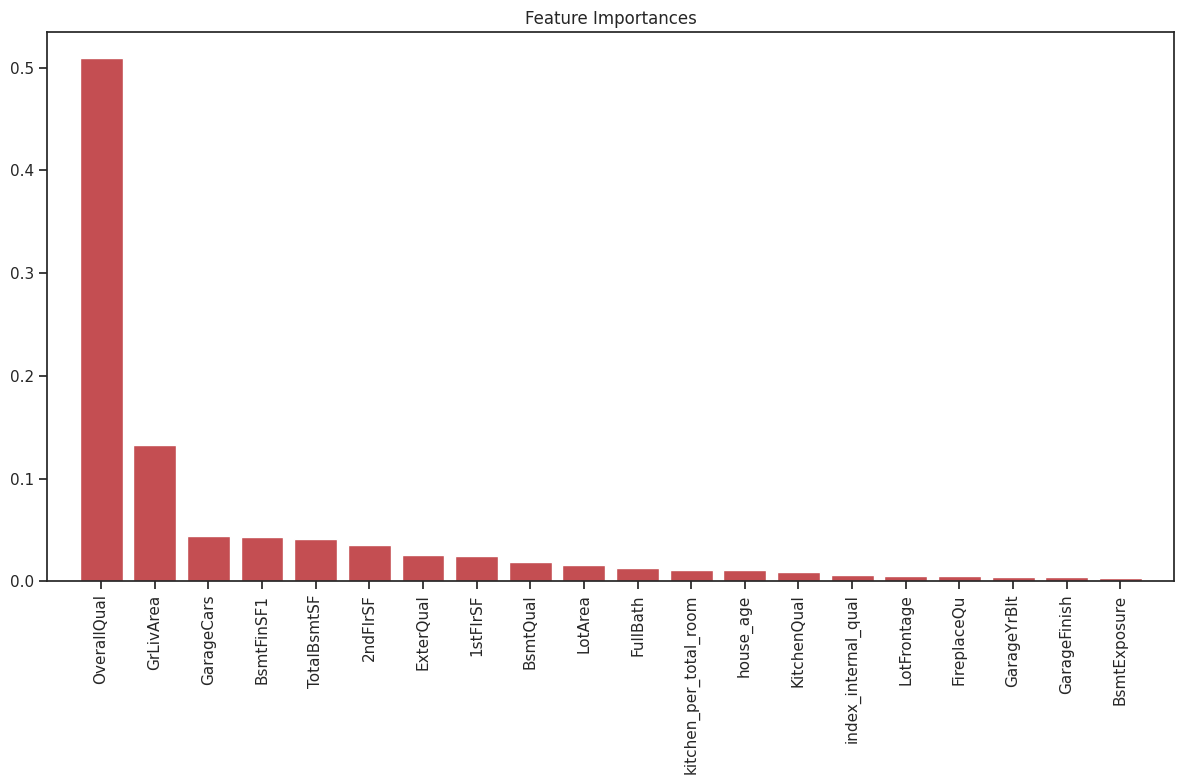

In [1026]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor

# Supondo que você já tenha processado o DataFrame e dividido os dados
processed_dataframe = process_dataframe(get_dataframe(path=PATH_TRAIN), remove_outliers=True)
X_train, X_val, y_train, y_val = get_train_test_split(processed_dataframe)

# Seleciona as colunas numéricas, excluindo 'SalePrice' e 'Id'
numeric_cols = processed_dataframe.select_dtypes(include=['number']).columns.tolist()
numeric_cols.remove('SalePrice')
numeric_cols.remove('Id')

# Treina o modelo
clf = GradientBoostingRegressor().fit(X_train[numeric_cols], y_train)

# Importância das features
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Nome das features
feature_names = X_train[numeric_cols].columns

# Defina quantas features você quer visualizar (20 neste caso)
num_features = 20

# Plotar as features mais importantes
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(num_features), importances[indices][:num_features], color="r", align="center")
plt.xticks(range(num_features), feature_names[indices][:num_features], rotation=90)
plt.xlim([-1, num_features])
plt.tight_layout()
plt.show()

In [673]:
def cross_val_estimators(X, y):
    d = {'models': [], 'score': [], 'std': []}

    for estimator in estimators:
        scores = cross_val_score(estimator=estimator, X=X, y=y, cv=5, scoring=rmse_log_scorer)
        d['models'].append(type(estimator).__name__)
        d['score'].append(-scores.mean()) 
        d['std'].append(scores.std())

    display_stats(d)

In [674]:
def cross_val_in_train_test_split():
    is_null = False
    
    processed_dataframe = process_dataframe(get_dataframe(path=PATH_TRAIN), remove_outliers=False)
    X_train, X_val, y_train, y_val = get_train_test_split(processed_dataframe)
    # X_train, X_val, y_train, y_val = obter_conj_treinamento_e_teste_estratificado_por(processed_dataframe, categoria='SalePrice')

    numeric_cols = processed_dataframe.select_dtypes(include=['number']).columns.tolist()
    numeric_cols.remove('SalePrice')
    numeric_cols.remove('Id')

    cols_with_null = processed_dataframe.columns[processed_dataframe.isna().any()].tolist()
    
    for numeric_col in numeric_cols:
        if numeric_col in cols_with_null:
            print(f" ### {numeric_col} is NULL ###")
            is_null = True
    
    if not is_null:
        cross_val_estimators(X=X_train[feature_names], y=y_train)
    else:
        print("Existem valores nulos nas colunas numéricas. Não é possível executar a validação cruzada.")

In [675]:
def validate_model(model, remove_outliers: bool = False):
    is_null = False
    
    processed_dataframe = process_dataframe(get_dataframe(path=PATH_TRAIN), remove_outliers=remove_outliers)
    X_train, X_val, y_train, y_val = get_train_test_split(processed_dataframe)

    numeric_cols = processed_dataframe.select_dtypes(include=['number']).columns.tolist()
    numeric_cols.remove('SalePrice')
    numeric_cols.remove('Id')

    cols_with_null = processed_dataframe.columns[processed_dataframe.isna().any()].tolist()
    for numeric_col in numeric_cols:
        if numeric_col in cols_with_null:
            print(f" ### {numeric_col} is NULL ###")
            is_null = True
    
    if not is_null:
        model.fit(X=X_train[numeric_cols], y=y_train)
        pred = model.predict(X=X_val[numeric_cols])
        
        # Calcule o logaritmo das previsões e dos valores observados
        log_pred = np.log(pred)
        log_y_val = np.log(y_val)
        
        # Calcule o RMSE entre os valores logaritmizados
        rmse = np.sqrt(mean_squared_error(log_y_val, log_pred))
        print(f"RMSE (logarithm of predictions and actual values): {rmse}")

#### chamada

In [957]:
cross_val_in_train_test_split()


 ********************** Starting FILL fields **********************

the columns ['Exterior1st', 'Fence'] was removed.
Fill LotFrontage: *** 0 *** values for replacement
Fill GarageType: *** 0 *** values for replacement
Fill GarageYrBlt: *** 0 *** values for replacement
Fill GarageFinish: *** 0 *** values for replacement
Fill GarageQual: *** 0 *** values for replacement
Fill GarageCond: *** 0 *** values for replacement
Fill BsmtQual: *** 0 *** values for replacement
Fill BsmtCond: *** 0 *** values for replacement
Fill BsmtExposure: *** 1 *** values for replacement
Fill BsmtFinType1: *** 0 *** values for replacement
Fill BsmtFinType2: *** 1 *** values for replacement
Fill MasVnrType: *** 0 *** values for replacement
Fill basement attributes: FireplaceQu
Fill FireplaceQu: *** 0 *** values for replacement
Fill PoolQC: *** 0 *** values for replacement
Fill Alley: *** 0 *** values for replacement
fill_columns_with_median_or_mode ....
Fill BsmtExposure: *** 0 *** values for replacement
Fill

                      models  score    std
2  GradientBoostingRegressor 0.1330 0.0139
4              LGBMRegressor 0.1386 0.0174
1        ExtraTreesRegressor 0.1400 0.0180
0      RandomForestRegressor 0.1435 0.0204
...
3          AdaBoostRegressor 0.1876 0.0239


Quantidade de Características: 42

#### Validação

In [ ]:
model = GradientBoostingRegressor()
validate_model(model)

RMSE (logarithm of predictions and actual values): 0.13848853102315625

## SUBIMIT

In [ ]:
train_processed = process_dataframe(get_dataframe(path=PATH_TRAIN), remove_outliers=False)

y_train = train_processed['SalePrice']
X_train = train_processed[selected_features]

estimator = GradientBoostingRegressor()
estimator.fit(X=X_train, y=y_train)

In [ ]:
test_to_predict = process_dataframe(get_dataframe(path=PATH_TEST), remove_outliers=False)
pred = estimator.predict(test_to_predict[selected_features])
d = {'Id': test_to_predict['Id'], 'SalePrice': pred}
submit = pd.DataFrame.from_dict(d)
submit.to_csv('prediction.csv', index=False)